# Notebook to compare anu-tub simulations

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as cm
import cftime as cft

In [2]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings for these docs

In [3]:
db = '/g/data/x77/amh157/anu-tub/diagnostics/anu-tub.db'
session=cc.database.create_session(db)

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45919,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:42007,Total threads: 4
Dashboard: /proxy/39917/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:40145,


# Runs to compare

For now, we only have:
* `anu-tub-n3`: The latest version of the `zstar` control run. Note that this simulation uses the `julian` calendar (a mistake).
* `anu-tub-hycom1`: Using the HYCOM1 coordinate from OM4.
* `anu-tub-n4`: A rerun and extension of `n3`
* `anu-tub-hycom1-500`: Using the HYCOM1 coordinate, from year 500 of `n4`.
* `anu-tub-adapt`: First attempt at the AG coord with default parameters.


In [5]:
#experiments=['anu-tub-n3','anu-tub-hycom1','anu-tub-adapt','anu-tub-n4','anu-tub-hycom1-500',]
experiments=['anu-tub-n4','anu-tub-adapt-n4',]

# Spinup Diagnostics

These are variables from `ocean.stats`. Note that the time axis on these files is incompatible with `xarray`, hence the `decode_times=False` argument below.

2024-07-17 20:36:41,967 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-f965c218-4a76-4dfc-9c63-1c060d19a753
State:     executing
Function:  execute_task
args:      ((<function apply at 0x14c876872830>, <function open_dataset at 0x14c85a67c790>, ['/g/data/x77/amh157/anu-tub/outputs/anu-tub-adapt-n4/output447/ocean.stats.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [['Time', 512]])], ['decode_times', False]])))
kwargs:    {}
Exception: "RuntimeError('NetCDF: Not a valid ID')"



RuntimeError: NetCDF: Not a valid ID

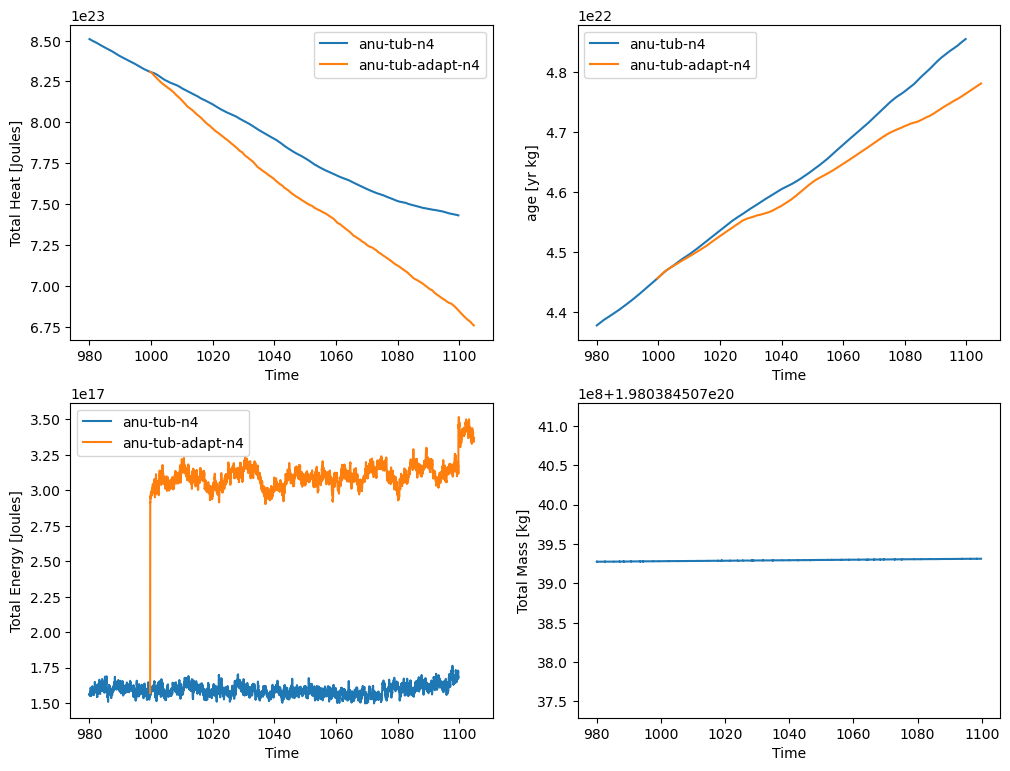

In [6]:
fig, ax = plt.subplots(2,2,figsize=(12,9))

tstart=980
tend = 1120

for experiment in experiments:
    variable = 'Heat'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sel(Time=slice(tstart,tend)).plot(ax=ax[0,0],label=experiment)

ax[0,0].legend()
                                               
for experiment in experiments:
    variable = 'En'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sel(Time=slice(tstart,tend)).plot(ax=ax[1,0],label=experiment)

ax[1,0].legend()

for experiment in experiments:
    variable = 'age'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sel(Time=slice(tstart,tend)).plot(ax=ax[0,1],label=experiment)

ax[0,1].legend()
                                         
for experiment in experiments:
    variable = 'Mass'
    darray = cc.querying.getvar(experiment, variable, session,ncfile='ocean.stats.nc',decode_times=False)
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sel(Time=slice(tstart,tend)).plot(ax=ax[1,1],label=experiment)

ax[1,1].legend()

# Extra Spinup Diagnostics

These diagnostics comes from regular diagnostic files. We are interested in the temperature evolution at different locations as well as some circulation metrics.

MemoryError: Task '_preprocess-798df1ea-9cbd-4980-aade-c3ef7e8f9843' has 12.89 GiB worth of input dependencies, but worker tcp://127.0.0.1:44413 has memory_limit set to 9.00 GiB.

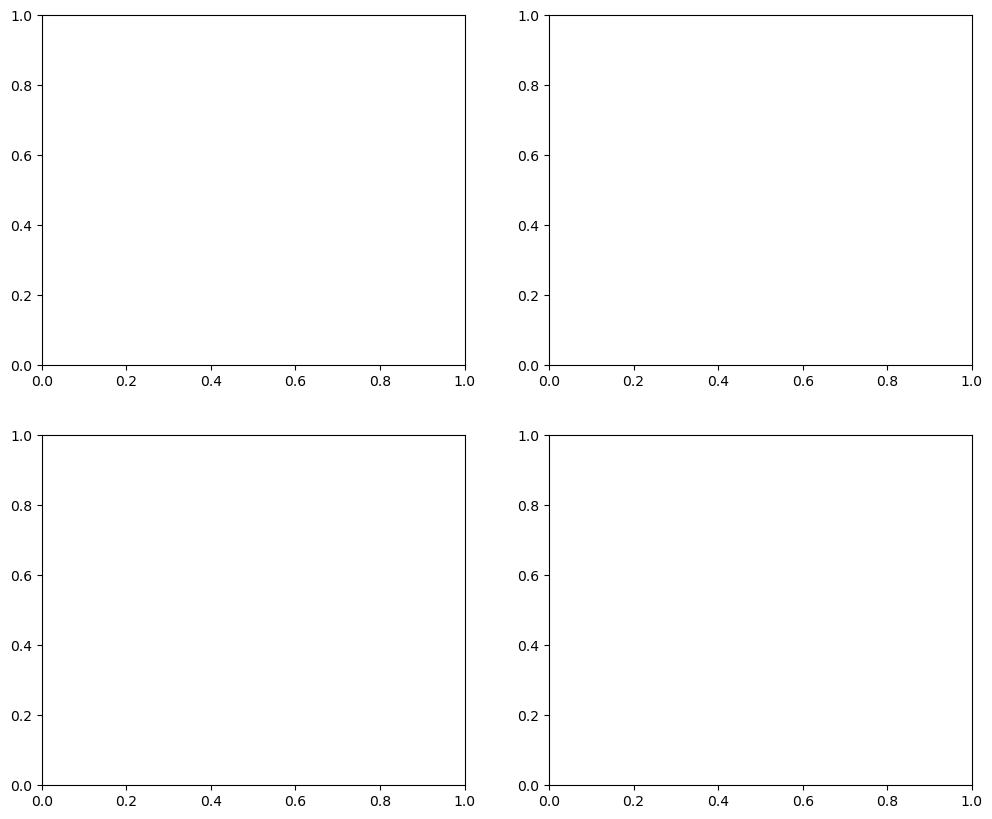

In [7]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

for experiment in experiments:
    darray = cc.querying.getvar(experiment, 'thetao', session,start_time='0980-01-01',attrs={'cell_methods':'area:mean z_l:mean yh:mean xh:mean time: mean'},decode_times=False)

    deep_temp = darray.sel(z_l=slice(2000,4000)).mean('z_l').sel(yh=slice(-30,30)).mean('yh').sel(xh=slice(10,30)).mean('xh')
    deep_temp.plot(ax=ax[0,0],label=experiment)
    
    shallow_temp = darray.sel(z_l=slice(0,200)).mean('z_l').sel(yh=slice(-30,30)).mean('yh').sel(xh=slice(10,30)).mean('xh')
    shallow_temp.plot(ax=ax[0,1],label=experiment)
    
    deep_temp_diff = darray.sel(z_l=slice(3000,4000)).mean('z_l').sel(yh=slice(50,62)).mean('yh').mean('xh') - darray.sel(z_l=slice(3000,4000)).mean('z_l').sel(yh=slice(-62,-50)).mean('yh').mean('xh')
    deep_temp_diff.plot(ax=ax[1,0],label=experiment)

    shelf_temp = darray.mean('z_l').sel(yh=slice(-70,-65)).mean('yh').mean('xh')
    shelf_temp.plot(ax=ax[1,1],label=experiment)

ax[0,0].legend()
ax[0,0].set_title('Deep Tropical Temperature evolution')

ax[0,1].legend()
ax[0,1].set_title('Shallow Tropical Temperature evolution')

ax[1,0].legend()
ax[1,0].set_title('Deep (Arctic - SO) Temperature Difference')

ax[1,1].legend()
ax[1,1].set_title('Antarctic Shelf Temp');

Text(0.5, 1.0, 'Abyssal Overturning Circulation (Sv)')

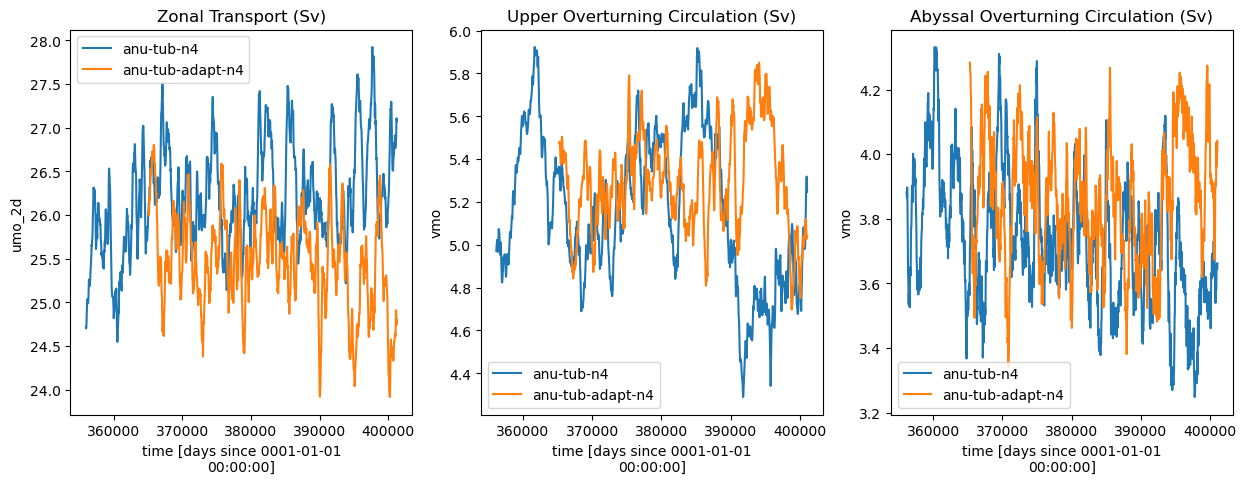

In [8]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

for experiment in experiments:
    darray = cc.querying.getvar(experiment, 'umo_2d', session, frequency='1 monthly',start_time='0980-01-01',decode_times=False)
    dp_trans = darray.isel(xq=0).sum('yh').rolling(time=12,center=True).mean().dropna('time').load()/1e9
    dp_trans.plot(ax=ax[0],label=experiment)

    darray = cc.querying.getvar(experiment, 'vmo', session,start_time='0980-01-01',decode_times=False)
    moc = darray.sum('xh').cumsum('rho2_l').sel(rho2_l=slice(1034,1038)).rolling(time=24,center=True).mean().dropna('time')/1e9
    amoc = moc.sel(yq=45,method='nearest').max('rho2_l').load()
    gmoc = -moc.sel(yq=-45,method='nearest').min('rho2_l').load()
    amoc.plot(ax=ax[1],label=experiment)
    gmoc.plot(ax=ax[2],label=experiment)
    
ax[0].legend()
ax[0].set_title('Zonal Transport (Sv)')
ax[1].legend()
ax[1].set_title('Upper Overturning Circulation (Sv)')
ax[2].legend()
ax[2].set_title('Abyssal Overturning Circulation (Sv)')

## Problem with `adapt-n4`

This plot shows sea level increasing by about 6 years per decade in the new adaptive run.

Text(0.5, 1.0, 'Height of SL above bottom')

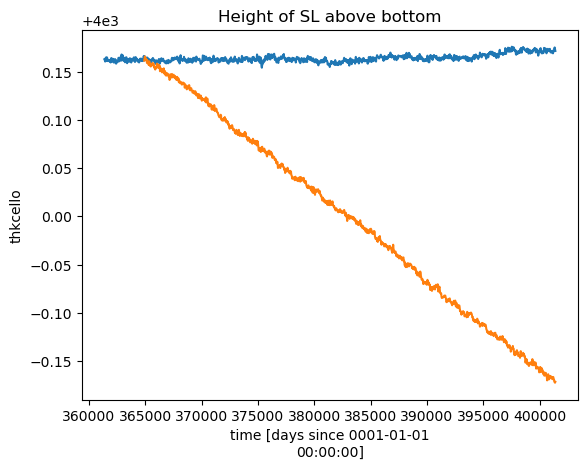

In [6]:
tstart=990*365
tend = 1100*365
for experiment in experiments:
    darray = cc.querying.getvar(expt=experiment, variable='thkcello', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'area:mean rho2_l:sum yh:mean xh:mean time: mean'},
                          decode_times=False)
    sea_level = darray.sel(time=slice(tstart,tend)).sum('rho2_l')
    sea_level.isel(yh=400).isel(xh=80).plot()

plt.title('Height of SL above bottom')

# Plotting some maps

Mean fields are averaged over the last 20 years of simulation. Snapshots take the last day simulated.

In [18]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[-70, -70],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=-70,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

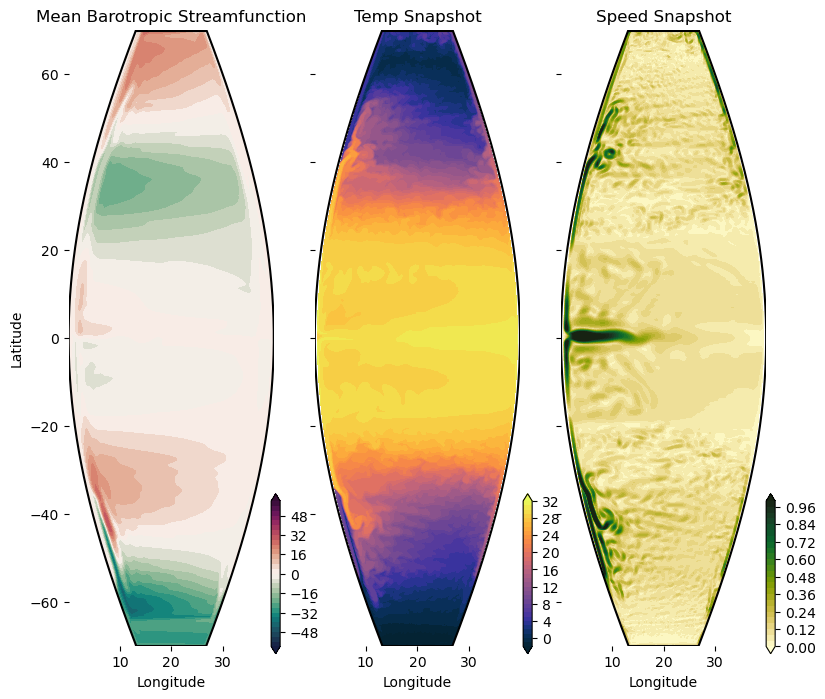

In [9]:
experiment = 'anu-tub-n4'
fig, ax = plt.subplots(1,3,figsize=(9,8))
vlev = np.linspace(-2,32,35)


darray = cc.querying.getvar(experiment, 'umo_2d', session,n=-20, frequency='1 monthly',decode_times=False)
psi = darray.mean('time').cumsum('yh').load()
psi = (psi - psi.isel(xq=-1).isel(yh=-1))/1e9
X,Y = plot_mercator(ax[0],psi.coords['xq'],psi.coords['yh'])
p1=ax[0].contourf(X,Y,psi,cmap=cm.cm.curl,levels=np.linspace(-60,60,31),extend='both')
ax[0].set_title('Mean Barotropic Streamfunction')
ax[0].set_ylabel('Latitude')

cbax = plt.axes([0.35,0.1,0.01,0.2])
plt.colorbar(p1,cbax)


darray = cc.querying.getvar(experiment, 'tos', session,n=-20,decode_times=False)
temp_snap = darray.isel(time=-1).load()
X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_snap.coords['yh'])
p1=ax[1].contourf(X,Y,temp_snap,levels=vlev,extend='both',cmap=cm.cm.thermal)
ax[1].set_title('Temp Snapshot')
ax[1].set_yticklabels('')

cbax = plt.axes([0.63,0.1,0.01,0.2])
plt.colorbar(p1,cbax)


slev = np.linspace(0,1,26)
darray = cc.querying.getvar(experiment, 'uo', session,n=-20,decode_times=False)
u_snap = darray.isel(time=-1).isel(z_l=0).load()
darray = cc.querying.getvar(experiment, 'vo', session,n=-20,decode_times=False)
v_snap = darray.isel(time=-1).isel(z_l=0).load()
speed = (u_snap.values[:,:-1]**2 + v_snap[:-1,:].values**2)**(0.5)
X,Y = plot_mercator(ax[2],temp_snap.coords['xh'],temp_snap.coords['yh'])
p1=ax[2].contourf(X,Y,speed,levels=slev,extend='both',cmap=cm.cm.speed)
ax[2].set_title('Speed Snapshot')
ax[2].set_yticklabels('')

cbax = plt.axes([0.9,0.1,0.01,0.2])
plt.colorbar(p1,cbax)
plt.savefig('figs/ModelSchematic.png')

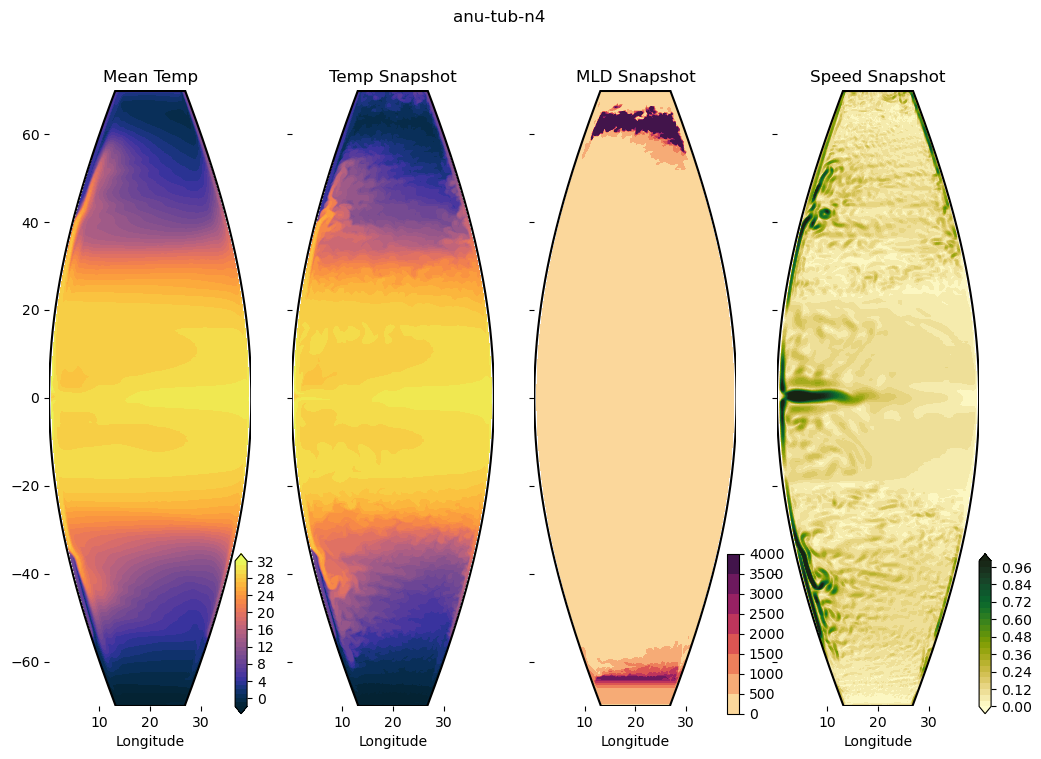

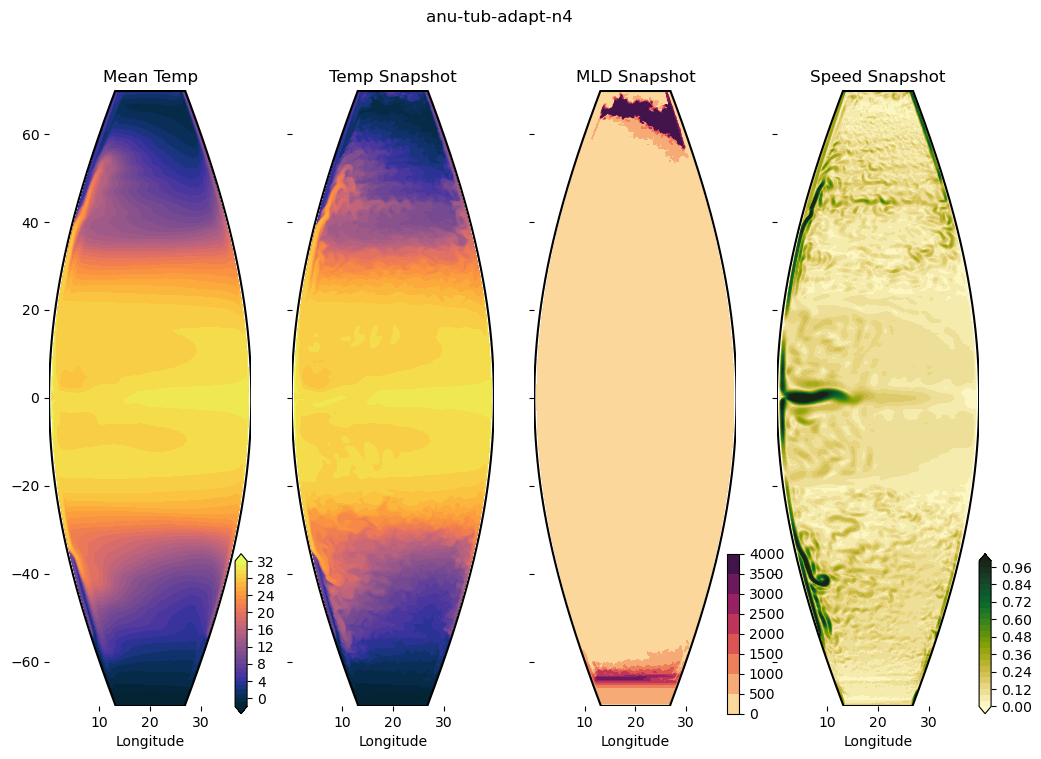

In [10]:
for experiment in experiments:
    fig, ax = plt.subplots(1,4,figsize=(12,8))
    vlev = np.linspace(-2,32,35)

    darray = cc.querying.getvar(experiment, 'tos', session,n=-20,decode_times=False)
    temp_surf = darray.mean('time').load()
    X,Y = plot_mercator(ax[0],temp_surf.coords['xh'],temp_surf.coords['yh'])
    p1=ax[0].contourf(X,Y,temp_surf,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[0].set_title('Mean Temp')
    
    darray = cc.querying.getvar(experiment, 'tos', session,n=-20,decode_times=False)
    temp_snap = darray.isel(time=-1).load()
    X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_snap.coords['yh'])
    p1=ax[1].contourf(X,Y,temp_snap,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[1].set_title('Temp Snapshot')
    ax[1].set_yticklabels('')
    
    cbax = plt.axes([0.28,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)

    darray = cc.querying.getvar(experiment, 'mlotst', session,n=-20,decode_times=False)
    mld_snap = darray.isel(time=-1).load()
    X,Y = plot_mercator(ax[2],mld_snap.coords['xh'],mld_snap.coords['yh'])
    p1=ax[2].contourf(X,Y,mld_snap,cmap=cm.cm.matter)
    ax[2].set_title('MLD Snapshot')
    ax[2].set_yticklabels('')


    cbax = plt.axes([0.69,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)
    
    slev = np.linspace(0,1,26)
    darray = cc.querying.getvar(experiment, 'uo', session,n=-20,decode_times=False)
    u_snap = darray.isel(time=-1).isel(z_l=0).load()
    darray = cc.querying.getvar(experiment, 'vo', session,n=-20,decode_times=False)
    v_snap = darray.isel(time=-1).isel(z_l=0).load()
    speed = (u_snap.values[:,:-1]**2 + v_snap[:-1,:].values**2)**(0.5)
    X,Y = plot_mercator(ax[3],temp_snap.coords['xh'],temp_snap.coords['yh'])
    p1=ax[3].contourf(X,Y,speed,levels=slev,extend='both',cmap=cm.cm.speed)
    ax[3].set_title('Speed Snapshot')
    ax[3].set_yticklabels('')

    cbax = plt.axes([0.9,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)
    
    plt.suptitle(experiment)


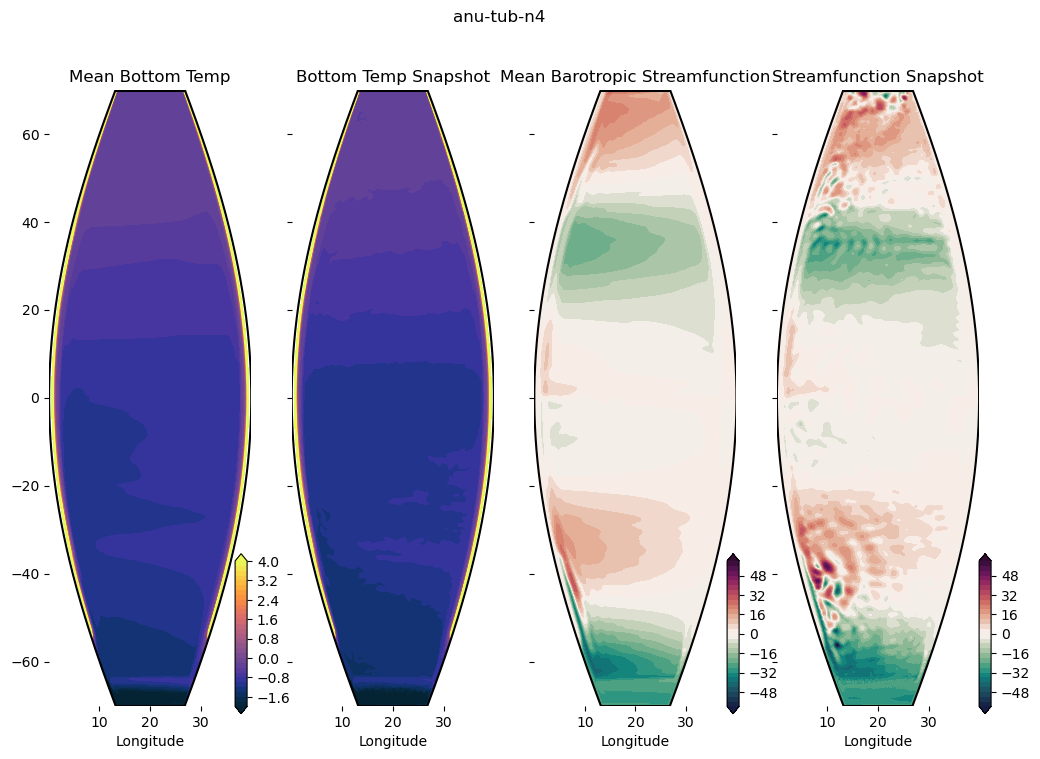

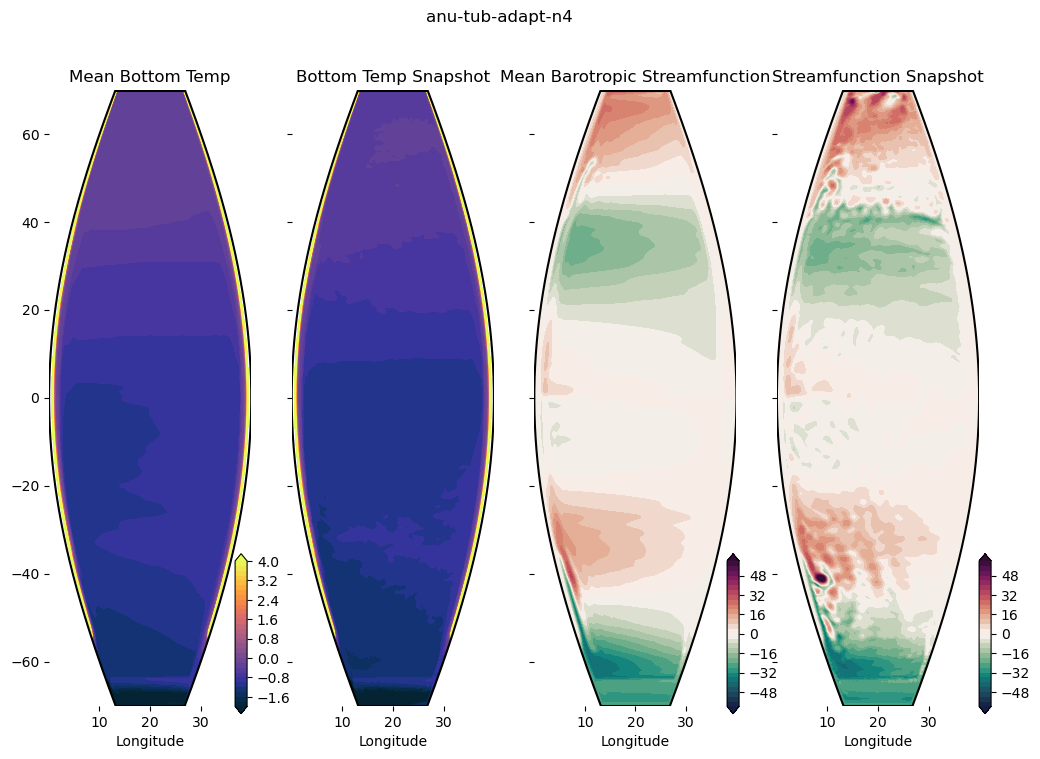

In [19]:
for experiment in experiments:

    fig, ax = plt.subplots(1,4,figsize=(12,8))
    vlev = np.linspace(-2,4,31)

    darray = cc.querying.getvar(experiment, 'tob', session,n=-20,decode_times=False)
    temp_surf = darray.mean('time').load()
    X,Y = plot_mercator(ax[0],temp_surf.coords['xh'],temp_surf.coords['yh'])
    p1=ax[0].contourf(X,Y,temp_surf,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[0].set_title('Mean Bottom Temp')

    darray = cc.querying.getvar(experiment, 'tob', session,n=-20,decode_times=False)
    temp_snap = darray.isel(time=-1).load()
    X,Y = plot_mercator(ax[1],temp_snap.coords['xh'],temp_snap.coords['yh'])
    p1=ax[1].contourf(X,Y,temp_snap,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[1].set_title('Bottom Temp Snapshot')
    ax[1].set_yticklabels('')

    cbax = plt.axes([0.28,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)


    darray = cc.querying.getvar(experiment, 'umo_2d', session,n=-20, frequency='1 monthly',decode_times=False)
    psi = darray.mean('time').cumsum('yh').load()
    psi = (psi - psi.isel(xq=-1).isel(yh=-1))/1e9
    X,Y = plot_mercator(ax[2],psi.coords['xq'],psi.coords['yh'])
    p1=ax[2].contourf(X,Y,psi,cmap=cm.cm.curl,levels=np.linspace(-60,60,31),extend='both')
    ax[2].set_title('Mean Barotropic Streamfunction')
    ax[2].set_yticklabels('')

    cbax = plt.axes([0.69,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)


    darray = cc.querying.getvar(experiment, 'umo_2d', session,n=-1, frequency='1 daily',decode_times=False)
    psi = darray.isel(time=-1).cumsum('yh').load()
    psi = (psi - psi.isel(xq=-1).isel(yh=-1))/1e9
    X,Y = plot_mercator(ax[3],psi.coords['xq'],psi.coords['yh'])
    p1=ax[3].contourf(X,Y,psi,cmap=cm.cm.curl,levels=np.linspace(-60,60,31),extend='both')
    ax[3].set_title('Streamfunction Snapshot')
    ax[3].set_yticklabels('')

    cbax = plt.axes([0.9,0.1,0.01,0.2])
    plt.colorbar(p1,cbax)
    
    plt.suptitle(experiment)


# Overturning Circulation


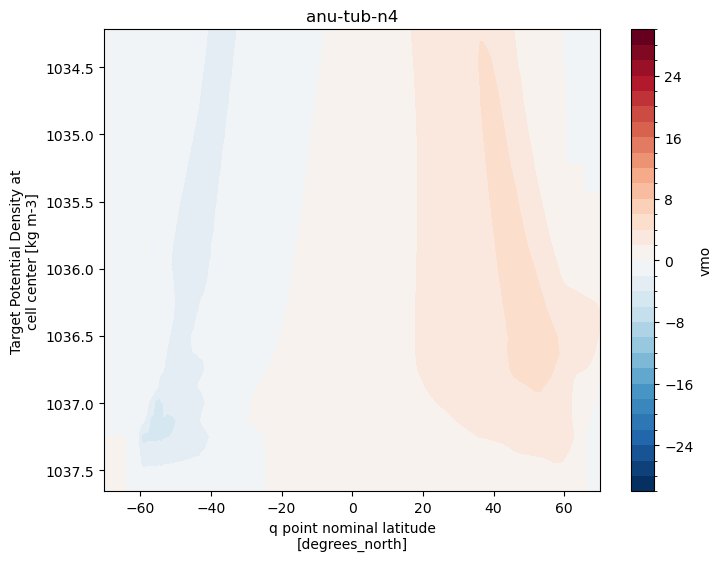

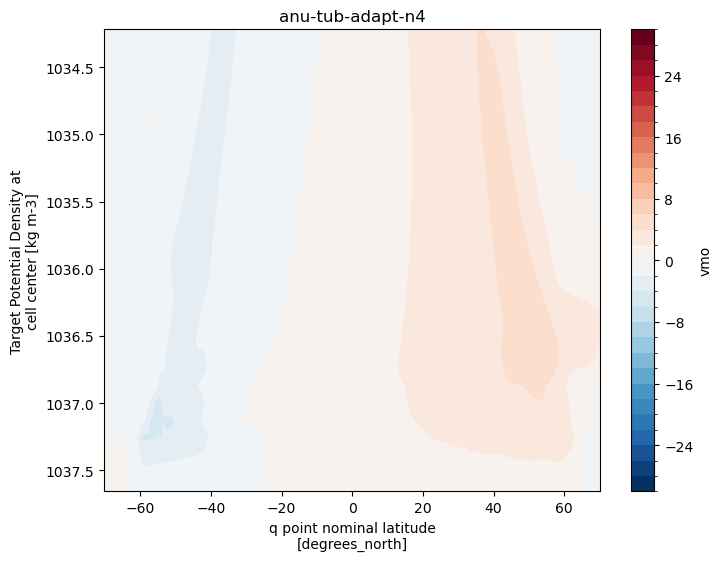

In [7]:
for experiment in experiments:
    fig = plt.figure(figsize=(8,6))
    darray = cc.querying.getvar(experiment, 'vmo', session,n=-20,decode_times=False)
    moc = darray.sum('xh').mean('time').cumsum('rho2_l')/1e9
    moc.sel(rho2_l=slice(1034,1038)).plot.contourf(levels=np.linspace(-30,30,31),yincrease=False)
    plt.title(experiment)

# Coordinate surfaces

<Figure size 1200x600 with 0 Axes>

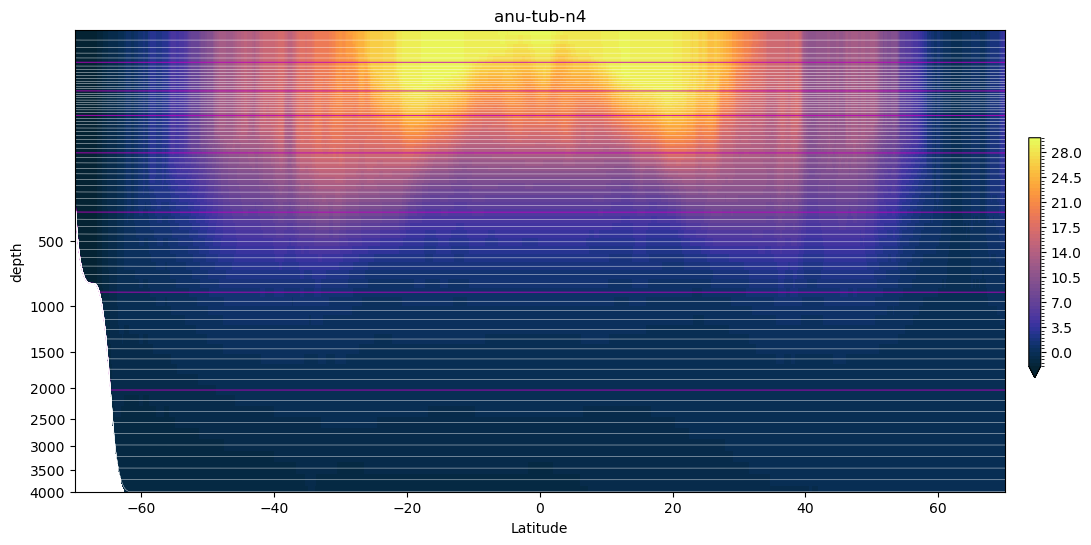

<Figure size 1200x600 with 0 Axes>

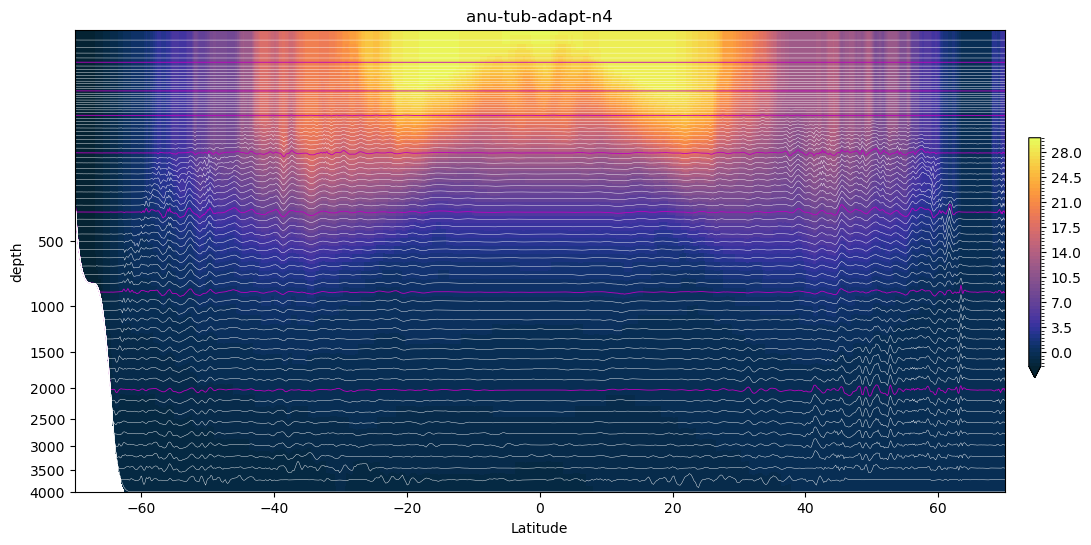

In [27]:
for experiment in experiments:
    plt.figure(figsize=(12,6))
    
    darray = cc.querying.getvar(experiment, 'thkcello', session,ncfile='ocean_month.nc',n=-1,decode_times=False).isel(time=0)
    depth = darray.isel(xh=40).cumsum('zl').values
    darray = cc.querying.getvar(experiment, 'thetao', session,ncfile='ocean_month.nc',n=-1,decode_times=False).isel(time=0)
    
    theta = xr.DataArray(data=darray.isel(xh=40).values,dims=["zl", "yh"],
            coords=dict(yh=(["yh"], darray.yh.values),depth=(["zl", "yh"], depth)),
            attrs= darray.attrs)

    plt.figure(figsize=(12,6))
    p1 = theta.plot(y = "depth",add_colorbar=False,levels=np.linspace(-2,30,65),cmap=cm.cm.thermal)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(theta.yh.values,depth[ii,:],'m',linewidth=0.6)
        else:
            plt.plot(theta.yh.values,depth[ii,:],'w',linewidth=0.3)
            
    def forward(x):
        return x**(1/3)
    def inverse(x):
        return x**3

    plt.xlim([-70,70])
    plt.ylim([2,4000])    
    plt.gca().set_yscale('function', functions=(forward, inverse))
    plt.gca().invert_yaxis()
    plt.xlabel('Latitude')
    plt.title(experiment)
    
    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)
    

# Along-layer gradients

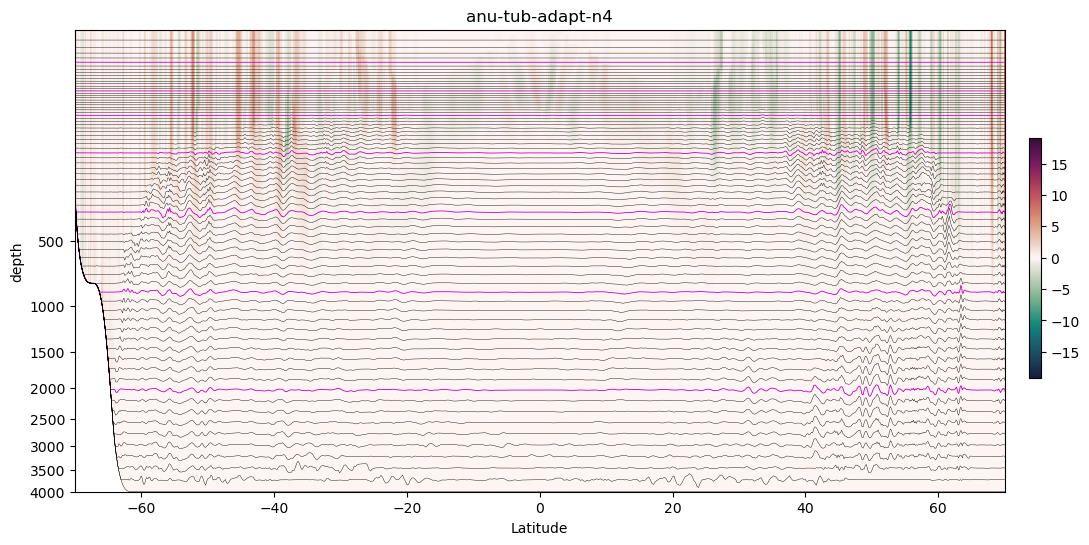

In [28]:
delT = theta.differentiate("yh")
plt.figure(figsize=(12,6))
p1 = delT.plot(y = "depth",add_colorbar=False,cmap=cm.cm.curl)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(theta.yh.values,depth[ii,:],'m',linewidth=0.6)
    else:
        plt.plot(theta.yh.values,depth[ii,:],'k',linewidth=0.3)
            
def forward(x):
    return x**(1/3)
def inverse(x):
    return x**3

plt.xlim([-70,70])
plt.ylim([2,4000])    
plt.gca().set_yscale('function', functions=(forward, inverse))
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.title(experiment)
    
ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)
    

<Figure size 1200x600 with 0 Axes>

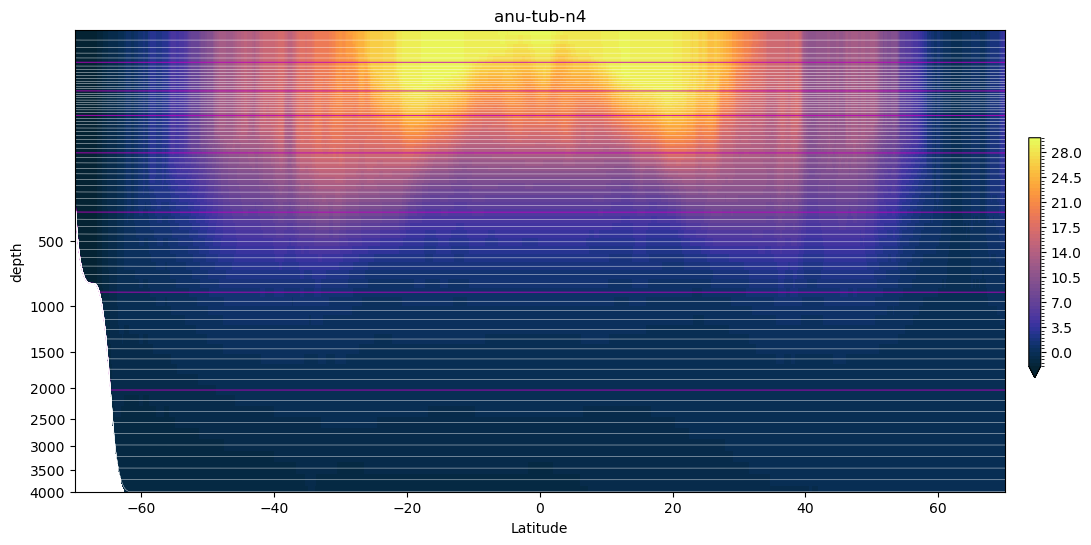

<Figure size 1200x600 with 0 Axes>

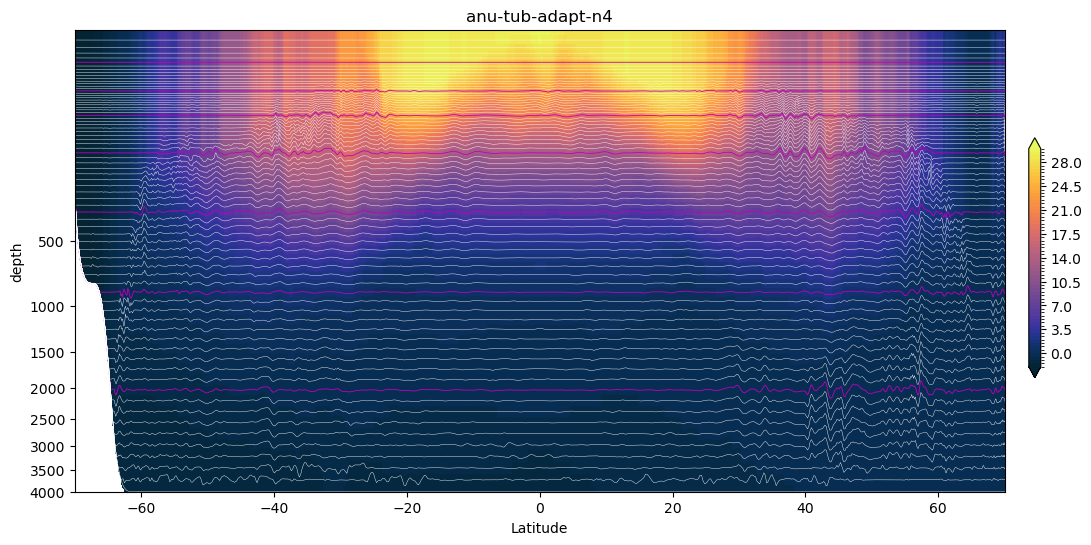

In [7]:
for experiment in experiments:
    plt.figure(figsize=(12,6))
    
    darray = cc.querying.getvar(experiment, 'thkcello', session,ncfile='ocean_month.nc',n=-1,decode_times=False).isel(time=0)
    depth = darray.isel(xh=40).cumsum('zl').values
    darray = cc.querying.getvar(experiment, 'thetao', session,ncfile='ocean_month.nc',n=-1,decode_times=False).isel(time=0)
    
    theta = xr.DataArray(data=darray.isel(xh=40).values,dims=["zl", "yh"],
            coords=dict(yh=(["yh"], darray.yh.values),depth=(["zl", "yh"], depth)),
            attrs= darray.attrs)

    plt.figure(figsize=(12,6))
    p1 = theta.plot(y = "depth",add_colorbar=False,levels=np.linspace(-2,30,65),cmap=cm.cm.thermal)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(theta.yh.values,depth[ii,:],'m',linewidth=0.6)
        else:
            plt.plot(theta.yh.values,depth[ii,:],'w',linewidth=0.3)
            
    def forward(x):
        return x**(1/3)
    def inverse(x):
        return x**3

    plt.xlim([-70,70])
    plt.ylim([2,4000])    
    plt.gca().set_yscale('function', functions=(forward, inverse))
    plt.gca().invert_yaxis()
    plt.xlabel('Latitude')
    plt.title(experiment)
    
    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)
    

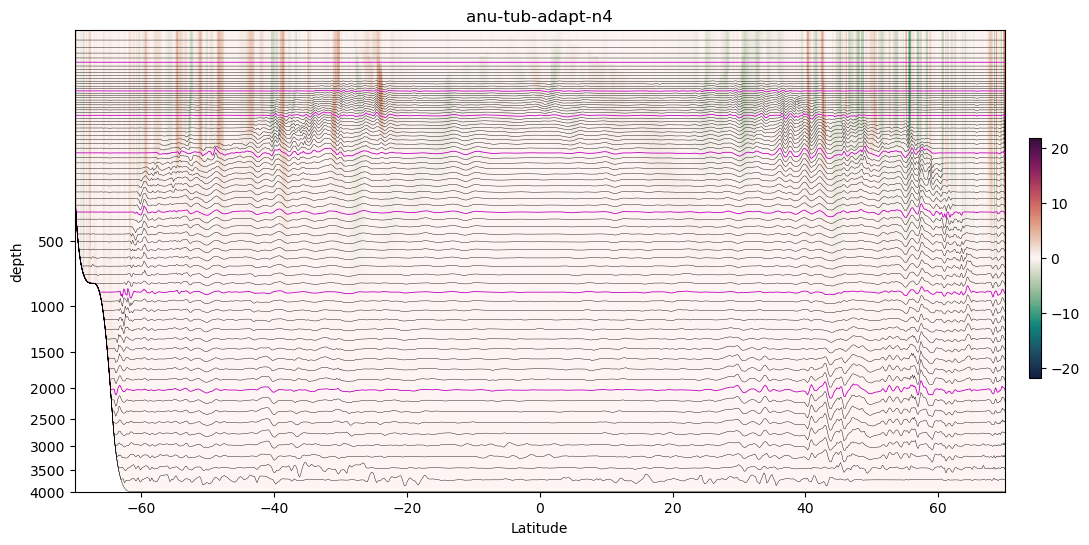

In [8]:
delT = theta.differentiate("yh")
plt.figure(figsize=(12,6))
p1 = delT.plot(y = "depth",add_colorbar=False,cmap=cm.cm.curl)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(theta.yh.values,depth[ii,:],'m',linewidth=0.6)
    else:
        plt.plot(theta.yh.values,depth[ii,:],'k',linewidth=0.3)
            
def forward(x):
    return x**(1/3)
def inverse(x):
    return x**3

plt.xlim([-70,70])
plt.ylim([2,4000])    
plt.gca().set_yscale('function', functions=(forward, inverse))
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.title(experiment)
    
ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)